<a href="https://colab.research.google.com/github/KonsumGandalf/proccessMining/blob/colab/proccessMining/src/data/course_python_data/Copy_of_3_7ConformanceCheckingEx2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
%pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.7 MB 7.5 MB/s 
     |████████████████████████████████| 205 kB 54.3 MB/s 
     |████████████████████████████████| 70 kB 7.7 MB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp37-cp37m-linux_x86_64.whl size=23587 sha256=30e4d1e92f787ab179a2819518aaf35377e52b5e15b18f89cd8d7913e5e21cac
  Stored in directory: /root/.cache/pip/wheels/d7/9c/d4/63bc3d8931de0980b9e4a724dea290bb40b8b1b2bd6227c8da
Successfully built stringdist


In [2]:
# Uplaod small source files
from google.colab import files
uploaded = files.upload()

Saving scenario1.pnml to scenario1.pnml


In [3]:
# Import a Petri Net using the PNML format 

from pm4py.objects.petri_net.importer import importer as pnml_importer
net, im, fm = pnml_importer.apply('scenario1.pnml')


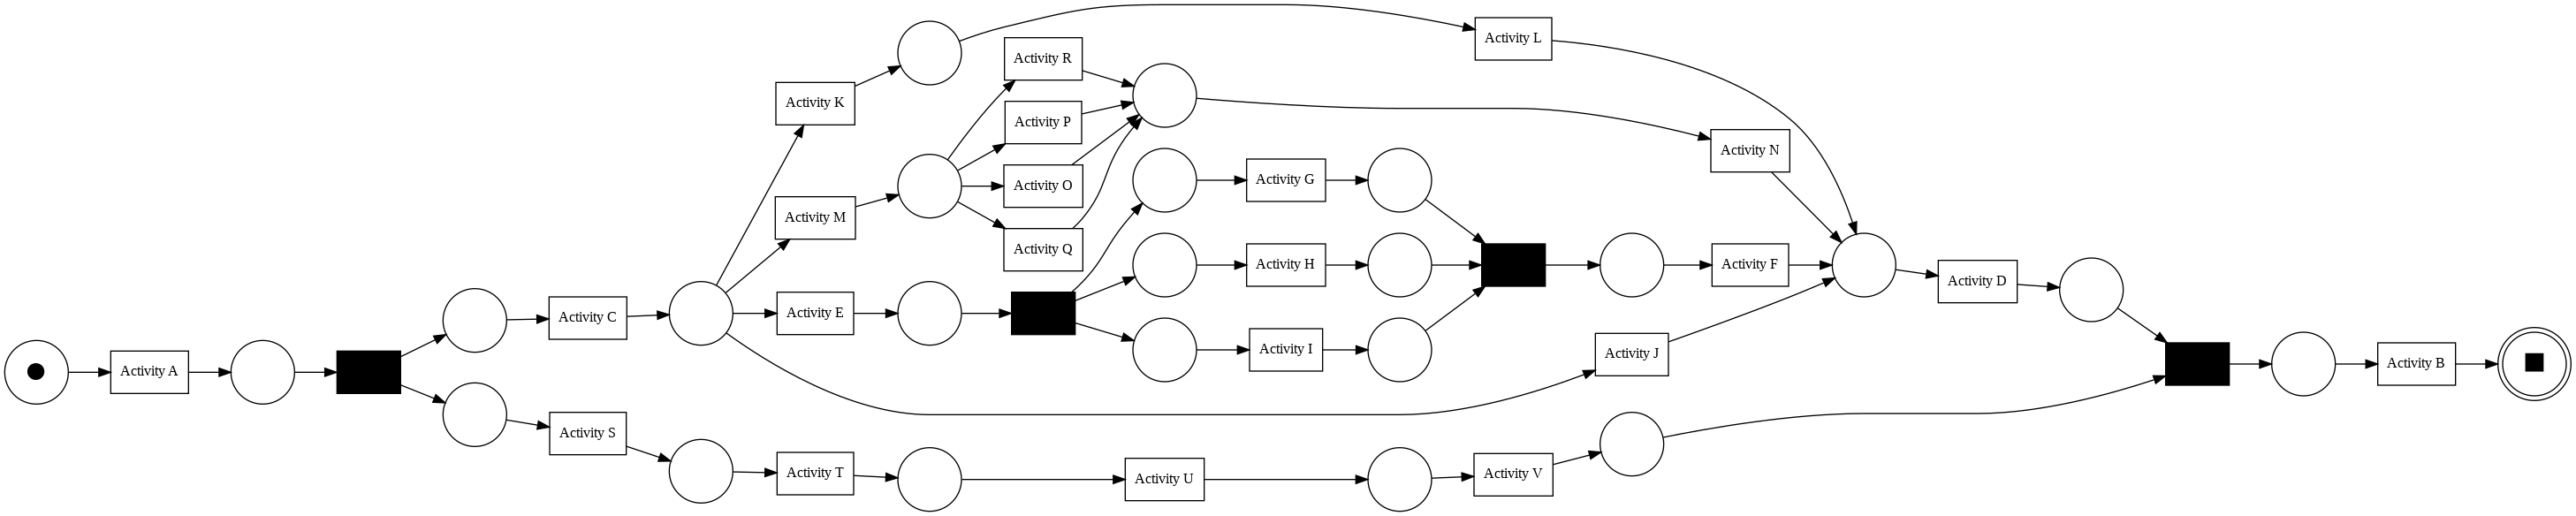

In [4]:
# Visualize the Petri Net

from pm4py.visualization.petri_net import visualizer as pn_visualizer
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


In [5]:
# Load Event Log
log_csv = pd.read_csv('https://raw.githubusercontent.com/paoloceravolo/PM-Regensburg/main/CCex2/scenario1_DepL.csv', sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

log_csv = log_csv.sort_values('timestamp')

log_csv.rename(columns={'timestamp': 'time:timestamp', 'case': 'case:concept:name', 'activity': 'concept:name', 'resource': 'org:resource'}, inplace=True)
parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'} # identify the case_id_key name (if not change it will simply be the mane of the coloumn)

# Convert the dataframe to an event log dictionary 

event_log = log_converter.apply(log_csv, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)

In [6]:
# Conformance Cheking
# Token-based replay matches a trace and a Petri net model,
# Alignment-based replay aims to find one of the best alignment between the trace and the model.

from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

In [7]:
# Alignment-based replay aims to find one of the best alignment between the trace and the model.

aligned_traces = alignments.apply_log(event_log, net, im, fm)

print("ALIGNMENTS")
print("Number of traces", len(aligned_traces))

#print(aligned_traces)

# Verify how many aligments are anomalous by considering their fitness attribute value
regular_traces = []
anomalous_traces = []
case_ids = []
i = 0
while i < len(aligned_traces):
	if aligned_traces[i]["fitness"] != 1:
		anomalous_traces.append(aligned_traces[i]['alignment'])
		case_ids.append(event_log[i].attributes["concept:name"])
	else:
		regular_traces.append(aligned_traces[i]['alignment'])
	i += 1
# print the list as a string
print(', '.join(map(str, case_ids)))
#print(anomalous_traces)
print("Number of anomalous traces ", len(anomalous_traces))
print("Number of normal traces ", len(regular_traces))
print("Percentage of anomalous traces", (len(anomalous_traces)/len(aligned_traces))*100 , '%')
print("Odds of anomalous traces", round(len(anomalous_traces)/len(regular_traces),2))


aligning log, completed variants ::   0%|          | 0/496 [00:00<?, ?it/s]

ALIGNMENTS
Number of traces 1000
38, 40, 69, 80, 99, 130, 145, 186, 221, 245, 284, 298, 303, 312, 350, 356, 362, 364, 371, 374, 377, 392, 452, 469, 545, 551, 553, 559, 564, 565, 568, 585, 589, 618, 635, 642, 676, 679, 698, 703, 724, 756, 774, 793, 801, 829, 867, 874, 943
Number of anomalous traces  49
Number of normal traces  951
Percentage of anomalous traces 4.9 %
Odds of anomalous traces 0.05


    Columns                      Mode  Mode freq.  Mode freq. %
0         0  (Activity A, Activity A)         951    100.000000
1         1                (>>, None)         951    100.000000
2         2  (Activity C, Activity C)         484     50.893796
3         3  (Activity C, Activity C)         246     25.867508
4         4  (Activity S, Activity S)         115     12.092534
5         5  (Activity S, Activity S)         171     17.981073
6         6  (Activity T, Activity T)         271     28.496320
7         7  (Activity U, Activity U)         326     34.279706
8         8  (Activity V, Activity V)         317     33.333333
9         9                (>>, None)         260     27.339642
10       10                (>>, None)         285     29.968454
11       11                (>>, None)         268     28.180862
12       12  (Activity B, Activity B)         237     24.921136
13       13  (Activity F, Activity F)         179     18.822292
14       14  (Activity D, Activity D)   

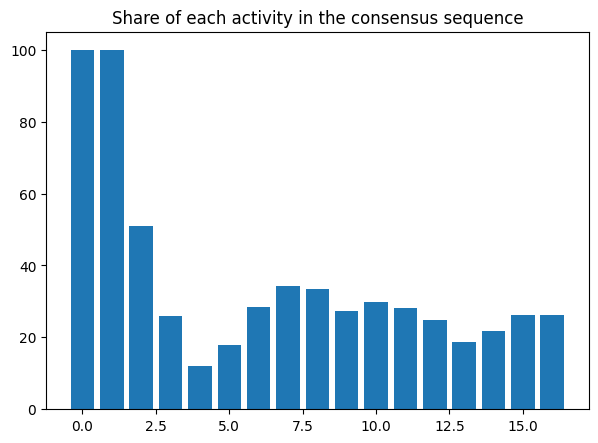

In [8]:
# Generate a Dataframe of the regular traces
regular_traces_df = pd.DataFrame(regular_traces)


# Generate the Consensus Sequence: The consensus sequence captures the major activity in each column and can be considered as a back-bone sequence for the process.

# For each column print the mode value, its absolute occurence, its relative occurence 
alignments_mode_count = pd.DataFrame({'Columns': regular_traces_df.columns,
                    'Mode':[regular_traces_df[x].mode()[0] for x in regular_traces_df],
                   'Mode freq.':[regular_traces_df[x].isin(regular_traces_df[x].mode()).sum() for x in regular_traces_df],
                   'Mode freq. %':[(regular_traces_df[x].isin(regular_traces_df[x].mode()).sum())/(len(regular_traces_df))*100 for x in regular_traces_df]
                   })
print(alignments_mode_count)

# Print the consenus sequence only 
consensus_sequence = alignments_mode_count['Mode'].tolist()
print(consensus_sequence)

# Visualize the share of each activity in the consensus sequence
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(alignments_mode_count['Columns'], height=alignments_mode_count['Mode freq. %'])
plt.title('Share of each activity in the consensus sequence');

,case:concept:name,concept:name,time:timestamp,actor,org:resource,label,description
0,0,Activity A,2020-06-15 00:14:31.200000+00:00,Lance,30,normal,normal case
1,0,Activity S,2020-06-15 00:16:31.200000+00:00,Gerald,70,normal,normal case
2,0,Activity C,2020-06-15 00:17:31.200000+00:00,Junior,10,normal,normal case
3,0,Activity K,2020-06-15 00:18:31.200000+00:00,Harper,80,normal,normal case
4,0,Activity T,2020-06-15 00:19:31.200000+00:00,Harper,80,normal,normal case
...,...,...,...,...,...,...,...
10800,999,Activity L,2020-07-05 08:14:30.582000+00:00,Stanley,30,normal,normal case
10801,999,Activity U,2020-07-05 08:15:30.582000+00:00,Quentin,10,normal,normal case
10802,999,Activity V,2020-07-05 08:16:30.582000+00:00,Brian,60,normal,normal case
10803,999,Activity D,2020-07-05 08:17:30.582000+00:00,Amy,10,normal,normal case


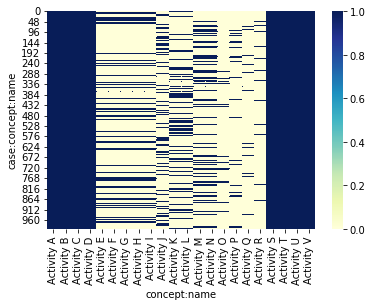

In [14]:
## Create a table giving the number of cases in which each event is present.
# we should reorder the list based on the model or the consensus list
events_share = pd.crosstab(log_csv['case:concept:name'], log_csv['concept:name'])
## Visualise in a heatmap
sns.heatmap(events_share, cmap="YlGnBu")
events_share
log_csv

In [18]:
## Generate a Dataframe of the rgular traces
anomalous_traces_df = pd.DataFrame(anomalous_traces)
#print(len(anomalous_traces_df))

## Visualise single trace
#print(list(anomalous_traces_df.loc[5]))
#print(anomalous_traces_df.loc[2][0][1])
#print(type(list(anomalous_traces_df.loc[5])[0]))


## For each element in the set of the anomalous traces run a procedure to Verify anomaly class of each move (misalignment between the model and the log) 

i =0
while i < len(anomalous_traces_df):

  ## Generate two lists, one for the model_moves and another for the log_moves

  # model_moves for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace.
  model_moves = []
  model_moves_pos = []
  # log_moves for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model.
  log_moves = []
  log_moves_pos = []

  # interate on a specific anomalous traces to extract the moves 
  # i is the anomalous trace, ii is the element in the trace
  for ii, x in enumerate(list(anomalous_traces_df.loc[i])):
    if x != None:
      if (x[0] == '>>' and x[1] != None):
        model_moves_pos.append((x[1], ii)) # if an activity specified in the model is missing in the log insert 
        model_moves.append(x[1]) # only activity without position 
      if x[1] == '>>':
        log_moves_pos.append((x[0], ii)) # if an activity observed in the log is missing in the model insert
        log_moves.append(x[0]) # only activity without position 

  print(model_moves_pos)
  #print(model_moves)
  print(log_moves_pos)
  #print(log_moves)

  ## Verify the anomaly classes by comparing the model_moves and log_moves lists

  # create a list to list the verified anomaly classes 
  anomal_class = []

  # the four anaomaly classes are defined based on two decision points on observing the model_moves and log_moves lists
  # the activity is in single list 1
  # the log came first 1
  # so we have 11 Insert, 10 Skip, 01 Early, 00 Late 
  if (len(model_moves)==0 and len(log_moves)==0): # the two lists are empty: no anomaly can be in the log 
    anomal_class.append(None)
  if (len(model_moves)!=0 and len(log_moves)!=0): # model_move and log_mode are not ampty: activity in a single list may be true or false
    for x in list(model_moves_pos):
      for xx in list(log_moves_pos):
        if (x[0] == xx[0] and x[1] < xx[1]): 
          anomal_class.append((x[0], 'Late')) # 00 activity in a single list is false, log come first is false
        if (x[0] not in log_moves):  
          anomal_class.append((x[0], 'Skip')) # 10 activity in a single list is true, log come first is false
        if (x[0] == xx[0] and x[1] > xx[1]): 
          anomal_class.append((x[0], 'Early')) # 01 activity in a single list is false, log come first is true
        if (xx[0] not in model_moves): 
          anomal_class.append((xx[0], 'Insert')) # 11 activity in a single list is true, log come first is true
  if (len(model_moves)!=0 and len(log_moves)==0): # 1 activity in a single list is true
    for x in model_moves:
      anomal_class.append((x, 'Skip')) # 10 log come first is false
  if (len(model_moves)==0 and len(log_moves)!=0): # 1 activity in a single list is true
    for x in log_moves:
      anomal_class.append((x, 'Insert')) # 11 log come first is true

  print(anomal_class)

  i += 1 # iterator of the while construct

[('Activity T', 3)]
[('Activity T', 9)]
[('Activity T', 'Late')]
[('Activity T', 4), ('Activity E', 5)]
[('Activity E', 11), ('Activity T', 12)]
[('Activity T', 'Late'), ('Activity E', 'Late')]
[('Activity K', 3)]
[('Activity K', 7)]
[('Activity K', 'Late')]
[('Activity T', 7)]
[('Activity T', 11)]
[('Activity T', 'Late')]
[('Activity D', 13)]
[('Activity D', 17)]
[('Activity D', 'Late')]
[('Activity V', 9)]
[('Activity V', 7)]
[('Activity V', 'Early')]
[('Activity N', 5)]
[('Activity N', 8)]
[('Activity N', 'Late')]
[('Activity G', 8)]
[('Activity G', 15)]
[('Activity G', 'Late')]
[('Activity C', 3)]
[('Activity C', 7)]
[('Activity C', 'Late')]
[('Activity K', 4)]
[('Activity K', 9)]
[('Activity K', 'Late')]
[('Activity C', 2)]
[('Activity C', 9)]
[('Activity C', 'Late')]
[('Activity U', 5), ('Activity E', 6)]
[('Activity U', 14), ('Activity E', 15)]
[('Activity U', 'Late'), ('Activity E', 'Late')]
[('Activity T', 6)]
[('Activity T', 9)]
[('Activity T', 'Late')]
[('Activity T', 7)]
[(